In [1]:
import torch
import numpy as np
import matplotlib.pylab as plt
import cv2

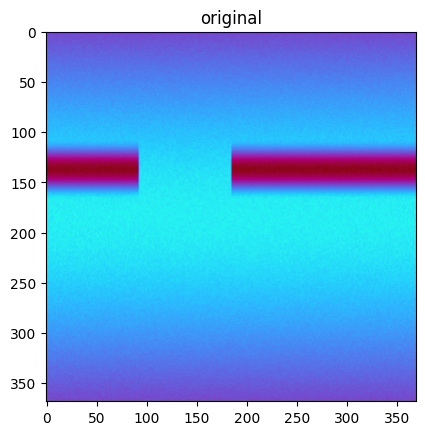

In [2]:
image = cv2.imread('newthermal.png')
plt.imshow(image)
plt.title('original')
plt.show()

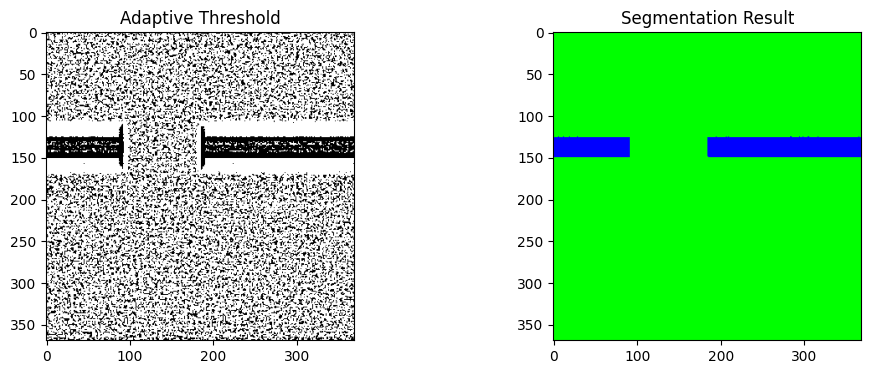

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('newthermal.png', cv2.IMREAD_GRAYSCALE)


BLOCK1_THRESHOLD = 220
BLOCK2_THRESHOLD_LOW = 80
BLOCK2_THRESHOLD_HIGH = 220


thresh_adaptive = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(thresh_adaptive, cv2.MORPH_CLOSE, kernel)

mask_block1 = np.zeros_like(image)
mask_block2 = np.zeros_like(image)
mask_water = np.zeros_like(image)

mask_block1[image > BLOCK1_THRESHOLD] = 255
mask_block2[(image > BLOCK2_THRESHOLD_LOW) & (image <= BLOCK2_THRESHOLD_HIGH)] = 255
mask_water[image <= BLOCK2_THRESHOLD_LOW] = 255

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(thresh_adaptive, cmap='gray')
plt.title('Adaptive Threshold')


plt.subplot(122)

result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
result[mask_block1 > 0] = [255, 0, 0]  
result[mask_block2 > 0] = [0, 255, 0]  
result[mask_water > 0] = [0, 0, 255]  

plt.imshow(result)
plt.title('Segmentation Result')

plt.show()


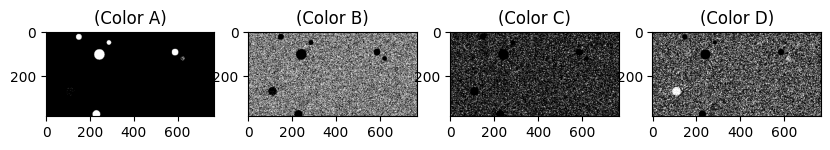

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('tempvariations.png')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


pixels = image_rgb.reshape((-1, 3))

np.random.seed(42)

k = 4
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels.astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

segmentation = labels.reshape(image.shape[0], image.shape[1])

mask_A = np.uint8(segmentation == 0) * 255
mask_B = np.uint8(segmentation == 1) * 255
mask_C = np.uint8(segmentation == 2) * 255
mask_D = np.uint8(segmentation == 3) * 255

color_A = [255, 0, 0]  
color_B = [0, 255, 0]  
color_C = [0, 0, 125]  
color_D = [0, 0, 0] 
result = np.zeros_like(image)

result[mask_A > 0] = color_A
result[mask_B > 0] = color_B
result[mask_C > 0] = color_C
result[mask_D > 0] = color_D


plt.figure(figsize=(10, 4))

plt.subplot(141)
plt.imshow(mask_A, cmap='gray')
plt.title('(Color A)')

plt.subplot(142)
plt.imshow(mask_B, cmap='gray')
plt.title('(Color B)')

plt.subplot(143)
plt.imshow(mask_C, cmap='gray')
plt.title('(Color C)')

plt.subplot(144)
plt.imshow(mask_D, cmap='gray')
plt.title('(Color D)')

plt.show()


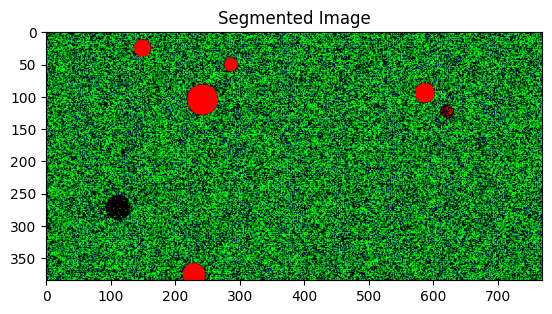

In [5]:
plt.imshow(result)
plt.title('Segmented Image')
plt.show()

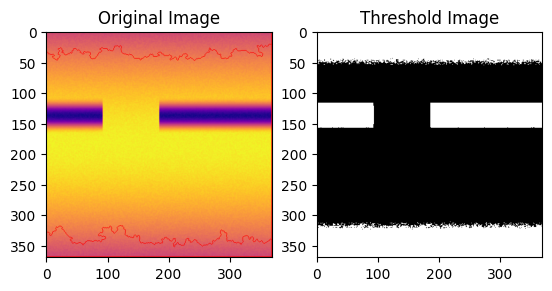

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread('newthermal.png')


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)


sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

cv2.watershed(img, markers)

img[markers == -1] = [0, 0, 255] 
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(thresh, cmap='gray'), plt.title('Threshold Image')

plt.show()


In [7]:
def EndToEndDistance(blob_image):
    binary_image = blob_image.astype(np.uint8)
    _, labels, _, _ = cv2.connectedComponentsWithStats(binary_image)
    print("Total Blobs are : ", len(np.unique(labels)) - 1)

    if len(np.unique(labels)) >= 2:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binary Image')

        plt.subplot(1, 2, 2)
        plt.imshow(binary_image, cmap='gray')

        all_distances = []

        for i in range(1, len(np.unique(labels))):
            for j in range(i + 1, len(np.unique(labels))):
                blob_mask1 = (labels == i).astype(np.uint8)
                blob_mask2 = (labels == j).astype(np.uint8)

                contours1, _ = cv2.findContours(blob_mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                contours2, _ = cv2.findContours(blob_mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours1 and contours2:
                    hull1 = cv2.convexHull(contours1[0])
                    hull2 = cv2.convexHull(contours2[0])

                    points_hull1 = hull1[:, 0, :]
                    points_hull2 = hull2[:, 0, :]

                    distance = np.linalg.norm(points_hull1[:, np.newaxis, :] - points_hull2, axis=2)
                    min_distance = np.min(distance)

                    all_distances.append(min_distance)

                    for d in distance:
                        plt.plot(points_hull1[:, 0], points_hull1[:, 1], 'r-')
                        plt.plot(points_hull2[:, 0], points_hull2[:, 1], 'b-')

        if all_distances:
            print("All Distances:", all_distances)
            plt.show()
        else:
            print("Contours not found for one or more blobs.")
    else:
        print("There are less than two blobs in the image.")

In [8]:
def CentroidDistance(blob_image):
    binary_image = blob_image.astype(np.uint8)
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

    if len(centroids) >= 2:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(binary_image, cmap='gray')
        plt.title('Binary Image')

        blob_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        
        for i in range(1, len(centroids)):
            cv2.circle(blob_image_rgb, (int(centroids[i][0]), int(centroids[i][1])), 5, (255, 0, 0), -1)
        
        plt.subplot(1, 3, 2)
        plt.imshow(blob_image_rgb)
        plt.title('Connected Centroids')

        all_distances = []
        
        for i in range(1, len(centroids)):
            for j in range(i + 1, len(centroids)):
                centroid_blob1 = centroids[i]
                centroid_blob2 = centroids[j]
                
                distance_between_blobs = np.linalg.norm(centroid_blob1 - centroid_blob2)
                all_distances.append(distance_between_blobs)

                plt.subplot(1, 3, 3)
                plt.imshow(blob_image_rgb)
                plt.plot([centroid_blob1[0], centroid_blob2[0]], [centroid_blob1[1], centroid_blob2[1]], 'r-')
                plt.title('Distances between Centroids')

        if all_distances:
            print("All Distances between Centroids:", all_distances)
            plt.show()
        else:
            print("Distances not found for one or more blobs.")
    else:
        print("There are less than two blobs in the image.")

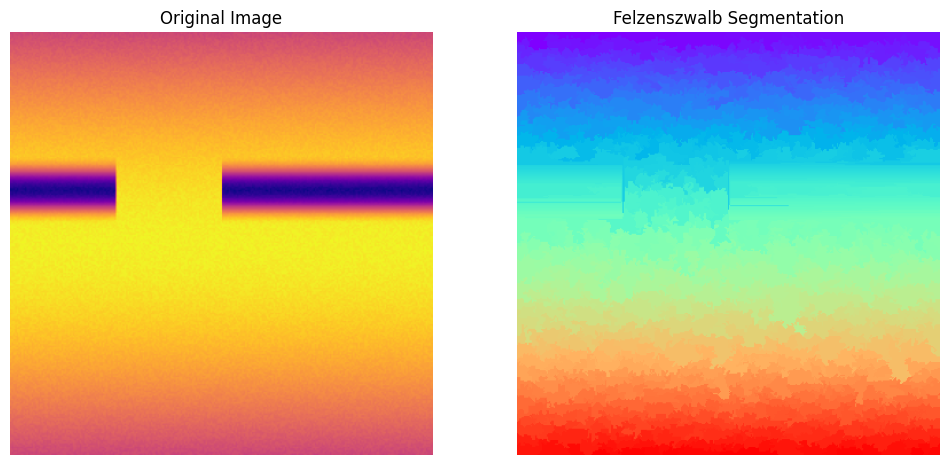

In [9]:
import numpy as np
import cv2
from skimage import segmentation, color
import matplotlib.pyplot as plt

def felzenszwalb_segmentation(image_path, scale=100, sigma=0.5, min_size=50):

    image = cv2.imread(image_path)[...,::-1] 

    lab_image = color.rgb2lab(image)

    segments = segmentation.felzenszwalb(lab_image, scale=scale, sigma=sigma, min_size=min_size)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title('Original Image')

    ax[1].imshow(segments, cmap='rainbow')
    ax[1].set_title('Felzenszwalb Segmentation')

    for a in ax:
        a.axis('off')

    plt.show()

image_path = 'newthermal.png'
felzenszwalb_segmentation(image_path, scale=100, sigma=0.5, min_size=50)


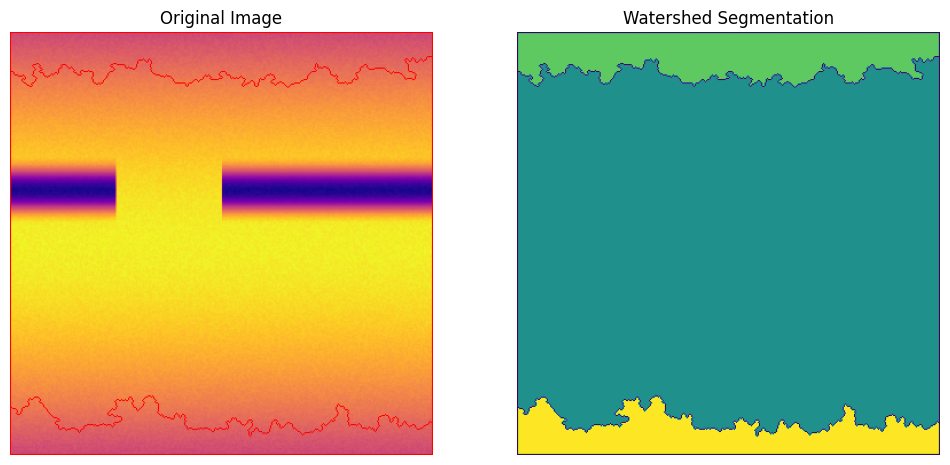

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def watershed_segmentation(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1

    markers[unknown == 255] = 0

    cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]  
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')

    ax[1].imshow(markers, cmap='viridis')
    ax[1].set_title('Watershed Segmentation')

    for a in ax:
        a.axis('off')

    plt.show()

image_path = './newthermal.png'
watershed_segmentation(image_path)


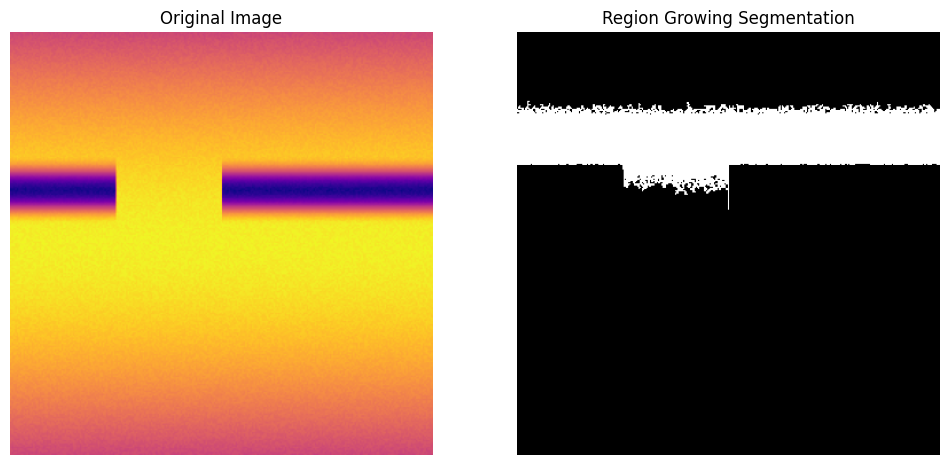

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = np.zeros_like(gray, dtype=np.uint8)

    tolerance = 20  
    queue = [seed]

    while queue:
    
        current_point = queue.pop(0)
        x, y = current_point

        if 0 <= x < gray.shape[0] and 0 <= y < gray.shape[1]:
            if abs(int(gray[x, y]) - int(gray[seed])) < tolerance and result[x, y] == 0:
                result[x, y] = 255
                queue.append((x + 1, y))
                queue.append((x - 1, y))
                queue.append((x, y + 1))
                queue.append((x, y - 1))

    return result


image_path = 'newthermal.png'
image = cv2.imread(image_path)

seed_point = (100, 100)

segmented_region = region_growing(image, seed_point)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')

ax[1].imshow(segmented_region, cmap='gray')
ax[1].set_title('Region Growing Segmentation')

for a in ax:
    a.axis('off')

plt.show()


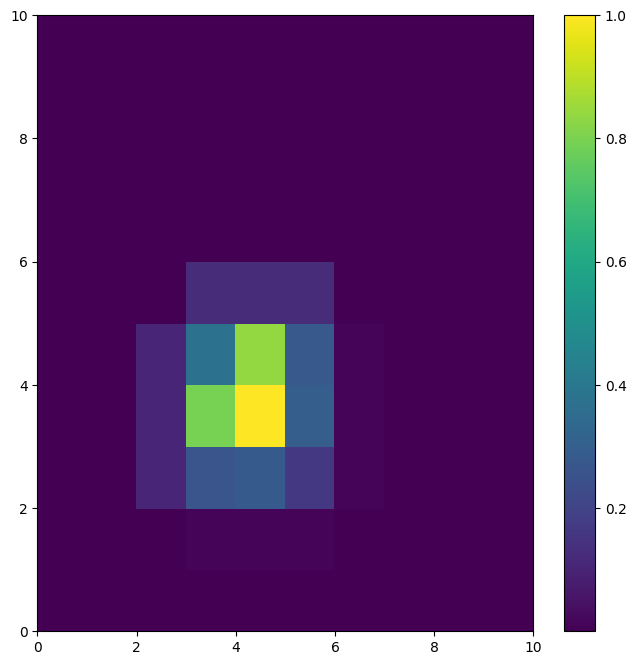

In [16]:
from minisom import MiniSom
som_shape = (10, 10) 
som = MiniSom(som_shape[0], som_shape[1], len(image_2d[0]), sigma=0.3, learning_rate=0.5)


som.train_random(image_2d, 1000)

plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T)
plt.colorbar()


plt.show()